## Import Packages

In [1]:
import numpy as np
import os
import seaborn as sn; sn.set(font_scale=1.4)
from sklearn.utils import shuffle           
import matplotlib.pyplot as plt             
import cv2                                 
import tensorflow as tf    

2023-06-08 16:42:59.503588: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-08 16:42:59.576379: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-08 16:42:59.576990: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-08 16:43:00.520294: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Dictionary mapping for labels

In [3]:
class_names = ['0','1','2','3']
class_names_label = {class_name:i for i, class_name in enumerate(class_names)}
nb_classes = len(class_names)
IMAGE_SIZE = (128, 128)

## Loading data

In [4]:

## Function definition
def load_data():
    
    datasets = ['/home/sky/Desktop/driver_drowsiness/dataset/train', '/home/sky/Desktop/driver_drowsiness/dataset/test']
    output = []
    
    # Iterate through training and test sets
    for dataset in datasets:
        
        images = []
        labels = []
        
        print("Loading {}".format(dataset))
        
        # Iterate through each folder corresponding to a category
        for folder in os.listdir(dataset):
            curr_label = class_names_label[folder]
            
            # Iterate through each image in our folder
            for file in os.listdir(os.path.join(dataset, folder)):
                
                # Get the path name of the image
                img_path = os.path.join(os.path.join(dataset, folder), file)
                
                # Open and resize the img
                curr_img = cv2.imread(img_path)
                curr_img = cv2.resize(curr_img, IMAGE_SIZE) 
                
                # Append the image and its corresponding label to the output
                images.append(curr_img)
                labels.append(curr_label)
                
        images = np.array(images, dtype = 'float32')
        labels = np.array(labels, dtype = 'int32')   
        
        output.append((images, labels))

    return output

## Function Call
(train_images, train_labels), (test_images, test_labels) = load_data()


Loading /home/sky/Desktop/driver_drowsiness/dataset/train
Loading /home/sky/Desktop/driver_drowsiness/dataset/test


## Scaling and shuffeling data

In [5]:
train_images = train_images / 255.0 
test_images = test_images / 255.0

train_images, train_labels = shuffle(train_images, train_labels)

In [6]:
train_images.shape

(2467, 150, 150, 3)

## Plotting sample images

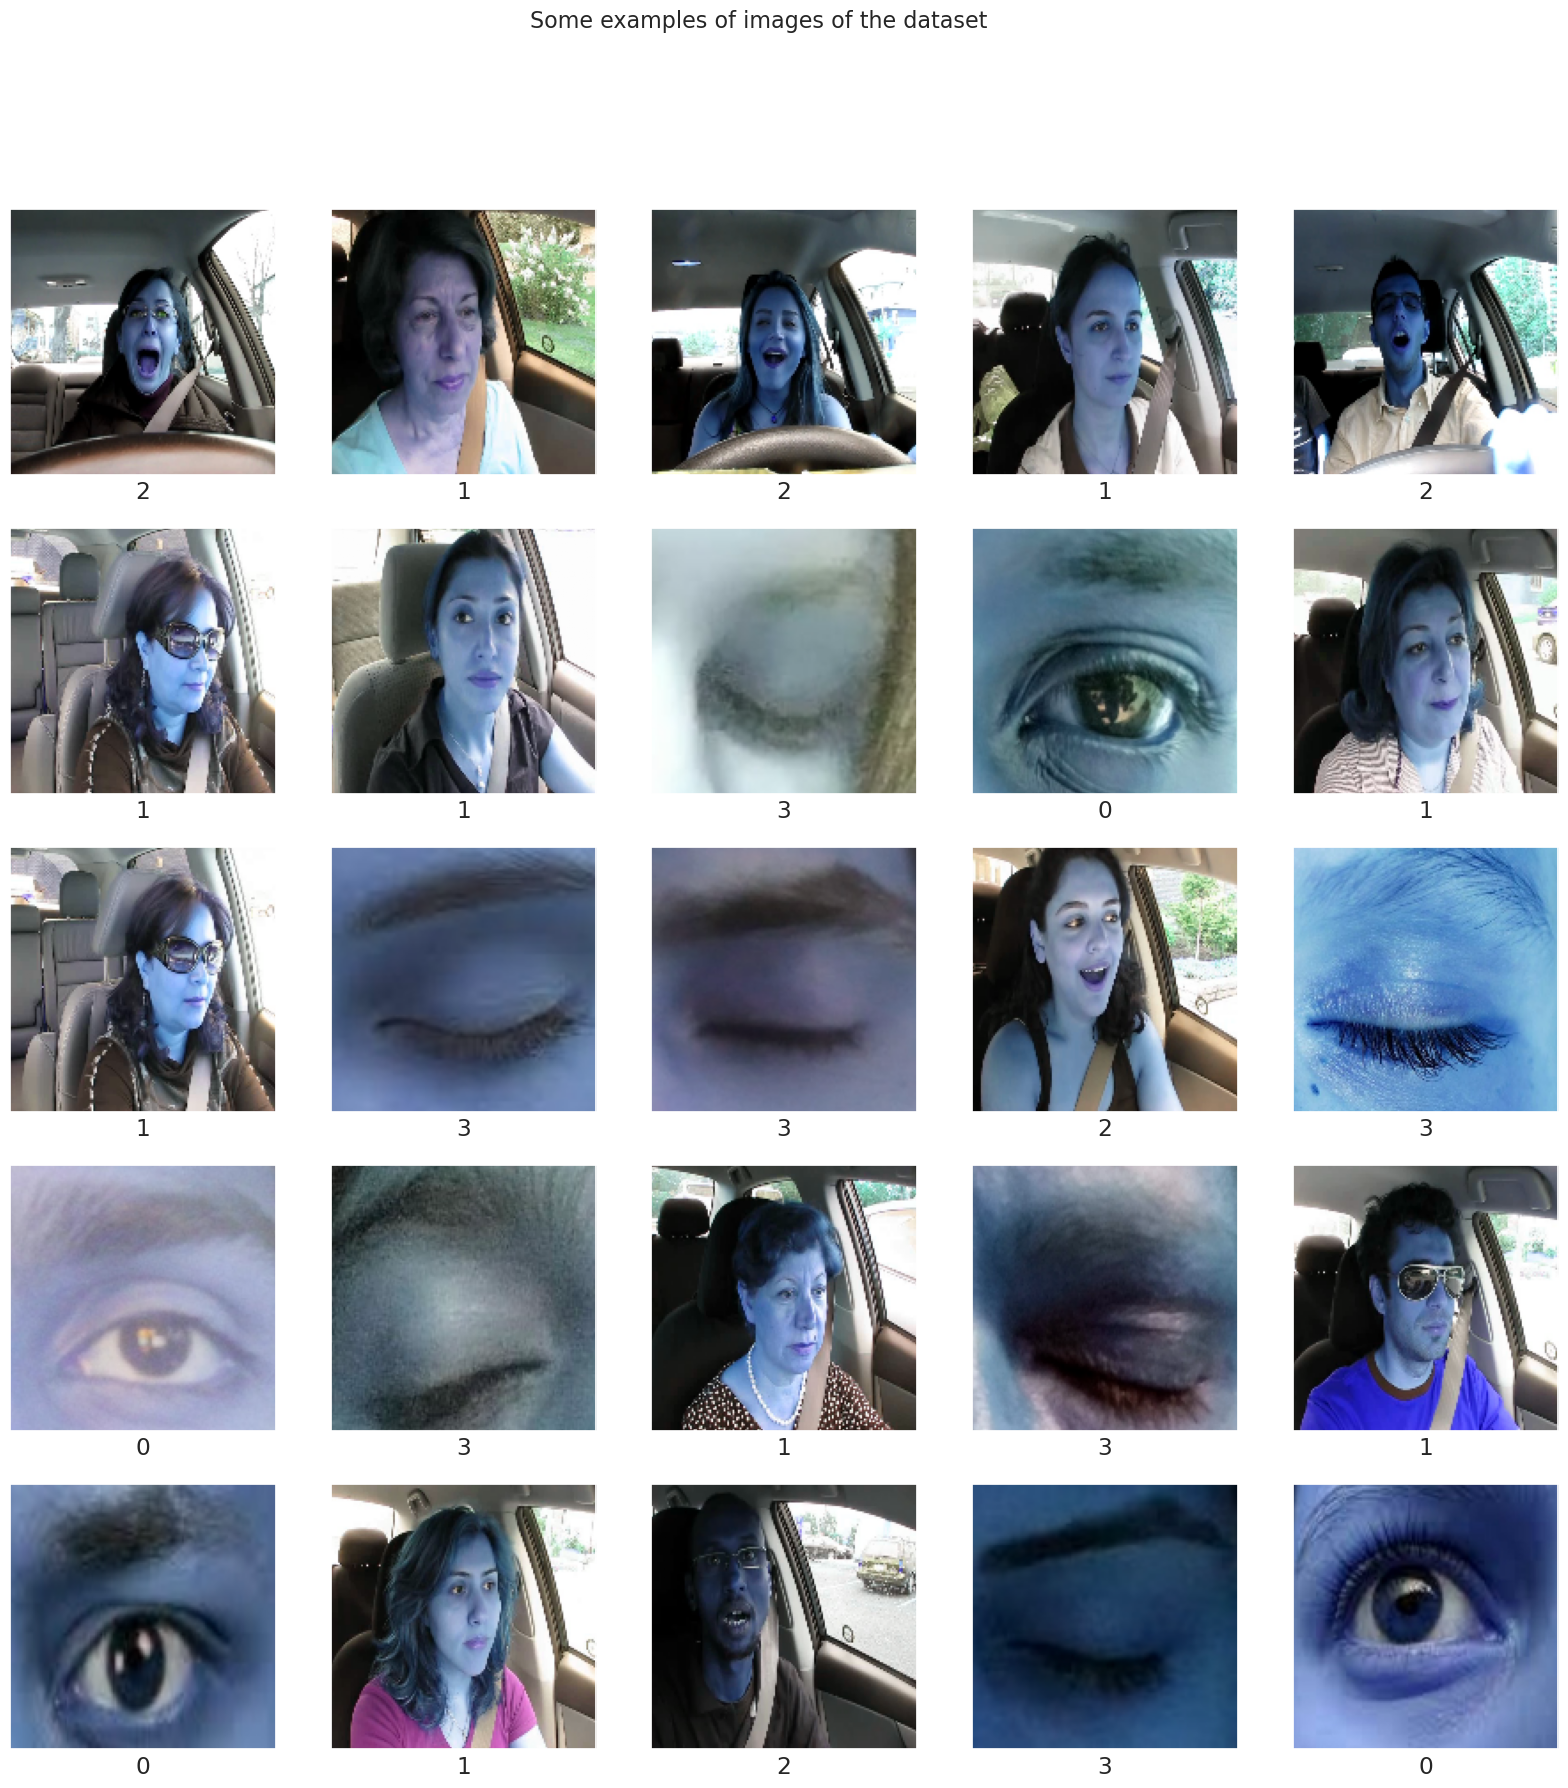

In [7]:
def display_examples(class_names, images, labels):
    """
        Display 25 images from the images array with its corresponding labels
    """
    
    fig = plt.figure(figsize=(20,20))
    fig.suptitle("Some examples of images of the dataset", fontsize=16)
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i])
        plt.xlabel(class_names[labels[i]])
    plt.show()

    ## Function call
display_examples(class_names, train_images, train_labels)


## Preparing target

In [8]:
from keras.utils import np_utils
y_train = np_utils.to_categorical(train_labels, 4)
y_test = np_utils.to_categorical(test_labels, 4)

## Transfer Learning using VGG16

In [9]:
from keras.applications import VGG16
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Activation, Conv2D, Flatten, BatchNormalization, Dropout, MaxPool2D
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

vgg_conv = VGG16(weights='imagenet',
                  include_top=False,input_shape=(128,128,3))
## Disabling training from VGG layers
vgg_conv.trainable=False

## Instantiating model
vgg_conv.trainable=False
transfer_model = Sequential()
transfer_model.add(vgg_conv)
transfer_model.add(Flatten())
transfer_model.add(Dropout(0.25))
transfer_model.add(Dense(64, activation='relu'))
transfer_model.add(Dropout(0.25))
transfer_model.add(Dense(4, activation='softmax'))


## Model summary
transfer_model.summary()

58889256/58889256 [==============================] - 15s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dropout (Dropout)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 64)                524352    
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 4)                 260       
                                                        

## Compiling model

In [10]:
optimizer = Adam(lr=0.2e-3, beta_1=0.9, beta_2=0.999, amsgrad=False)

transfer_model.compile(optimizer,loss='binary_crossentropy',metrics=["accuracy"])

## I know binary_crossentropy is not recommended for multiclass problems.
## But I saw somebody use it and surprisingly it gave better results.

/home/sky/anaconda3/lib/python3.10/site-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


## Model training with real time data augmentation

In [ ]:
train_gen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

# fits the model on batches with real-time data augmentation:
history = transfer_model.fit_generator(train_gen.flow(train_images, y_train, batch_size=32),
                              steps_per_epoch=len(train_images) / 64, epochs=10,
                              validation_data = (test_images, y_test))

/tmp/ipykernel_6162/3608636214.py:11: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = transfer_model.fit_generator(train_gen.flow(train_images, y_train, batch_size=32),
2023-06-08 16:45:06.220438: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


Epoch 1/10


2023-06-08 16:45:06.967521: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 184320000 exceeds 10% of free system memory.
2023-06-08 16:45:07.074985: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 184320000 exceeds 10% of free system memory.
2023-06-08 16:45:07.521681: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 92160000 exceeds 10% of free system memory.
2023-06-08 16:45:07.667901: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 92160000 exceeds 10% of free system memory.


 1/38 [..............................] - ETA: 1:59 - loss: 0.7413 - accuracy: 0.1562

2023-06-08 16:45:09.423592: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 184320000 exceeds 10% of free system memory.


38/38 [==============================] - 141s 4s/step - loss: 0.4275 - accuracy: 0.5921 - val_loss: 0.2768 - val_accuracy: 0.7829
Epoch 2/10
 3/38 [=>............................] - ETA: 1:40 - loss: 0.3446 - accuracy: 0.5938

In [24]:
#transfer_model.save("/vgg_model.h5")